# Brunner Data Science Task #
## Premise ##
Eric has been tracking his bike commutes to and from work. My task is to tell a story with the data:
* What do I observe?
* Describe trends and changes over time
* What factors affect his time?
* What are the implications of my findings?
## Knowns ##
* The office is at 11 Stanwix St. and Eric lives in the Point Breeze area
* Eric's commute is downhill in the mornings and uphill in the evenings
* Eric recently got a Kona gravel bike with wider tires and felt slower on his 2 most recent rides

## Assumptions ##
* Eric's morning commute takes place between 6 and 8 am
* Eric's evening commute takes place between 5 and 7 pm

## Wrangling and EDA ##

In [6]:
import arviz as az
import xarray as xr
import pandas as pd
import scipy
import datetime as dt
from weather import get_pgh_weather
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import pymc as pm
import ipywidgets
from circular_hist import circular_hist
#from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Reading in the data and merging on the route column
times_df = pd.read_excel('data.xlsx', sheet_name = 'raw_data')
key_df = pd.read_excel('data.xlsx', sheet_name = 'route_lookup')
raw_df = times_df.merge(right = key_df, how = 'left', on = 'route')
raw_df.head()

,date,temperature_f,destination,time,route,distance_miles
0,2019-03-20,26,Work,00:36:36,A,7.4
1,2019-03-20,56,Home,00:40:54,A,7.4
2,2019-03-28,39,Work,00:35:01,A,7.4
3,2019-03-28,61,Home,00:39:20,A,7.4
4,2019-04-03,35,Work,00:36:49,A,7.4


In [8]:
raw_df.describe()

,date,temperature_f,distance_miles
count,125,125.000000,125.000000
mean,2021-02-12 21:30:14.400000,65.088000,7.414400
min,2019-03-20 00:00:00,26.000000,7.300000
25%,2019-07-23 00:00:00,57.000000,7.400000
50%,2021-05-20 00:00:00,65.000000,7.400000
75%,2022-06-29 00:00:00,75.000000,7.400000
max,2024-03-01 00:00:00,90.000000,8.300000
std,NaN,14.008071,0.124242


### Cleaning ###
Thankfully there are no missing values or data quality issues. I want to simplify the column names, change some data types, and calculate average speed next.

In [9]:
def clean_biking_data(input_df):
    ''' (DataFrame) -> DataFrame
    Returns a cleaned dataframe with simplified feature names, an average speed calculation,
    and rectified data types.
    '''
    output_df = pd.DataFrame()
    output_df['date'] = pd.to_datetime(input_df['date'], format = '%Y-%m-%d').dt.date
    output_df['weekday'] = pd.to_datetime(output_df['date']).dt.weekday.map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})
    output_df['temp_f'] = input_df['temperature_f']
    output_df['destination'] = input_df['destination']
    output_df['time'] = pd.to_timedelta(input_df['time'].astype(str))
    output_df['route'] = input_df['route']
    output_df['miles'] = input_df['distance_miles']
    output_df['avg_mph'] = (output_df['miles']/(output_df['time'].dt.total_seconds()/3600)).round(2)
    return output_df

In [10]:
# Cleaned data
df = clean_biking_data(raw_df)
df.head()

,date,weekday,temp_f,destination,time,route,miles,avg_mph
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06


#### Grabbing Rides Per Year by Destination for Later ####

In [133]:
def assign_year(row):
    year = row['date'].year
    return year

In [137]:
year_df = df.copy()
year_df['year'] = year_df.apply(lambda x: assign_year(x), axis = 1)
yearly_speeds = year_df.groupby(['year', 'destination'])['avg_mph'].mean().reset_index(drop = False)

In [102]:
df.groupby('destination')['time'].mean(numeric_only = False)

destination
Home   0 days 00:39:06.508196721
Work             0 days 00:33:04
Name: time, dtype: timedelta64[ns]

### Weather Consideration ###
When I used to bike to work, weather was a huge perceived factor in my commute. If the weather was bad enough, I wouldn't bike at all. Otherwise, conditions like temperature and precipitation affected my riding pace and route. Eric provided temperature data but I can also check if there was any precipitation during his commutes, assuming the time estimate is roughly accurate.

In [11]:
def add_weather(input_df):
    ''' (DataFrame) -> DataFrame
    Add the weather code to each commute segment.
    Assumption is morning commute occurs between 6am and 8am. 
    Evening commute occurs between 5pm and 7pm.
    Applies "worst" weather code that occurred during commute.
    '''
    output_df = pd.DataFrame()
    for date in input_df['date'].unique():
        weather_data = get_pgh_weather(date)
        today_df = input_df.loc[input_df['date'] == date] 
        # Merge weather data with input_df based on 'date' and 'destination'
        merged_df = pd.merge(today_df, weather_data, on=['date', 'destination'], how='left')
        
        # Append merged_df to output_df
        output_df = pd.concat([output_df, merged_df], ignore_index=True)
    
    return output_df

In [12]:
full_df = add_weather(df)
full_df

,date,weekday,temp_f,destination,time,route,miles,avg_mph,weather_code,wind_speed_10m,wind_direction_10m
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13,1,3.537464,124.613930
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86,2,7.306211,191.514572
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68,0,7.502218,180.815369
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29,3,12.417627,225.371933
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06,0,5.557338,220.237610
...,...,...,...,...,...,...,...,...,...,...,...
120,2023-09-06,Wednesday,73,Work,0 days 00:31:29,A,7.4,14.10,0,3.019025,157.499985
121,2023-09-06,Wednesday,90,Home,0 days 00:40:36,F,7.4,10.94,0,7.765420,224.712799
122,2024-02-09,Friday,45,Work,0 days 00:34:55,A,7.4,12.72,2,7.922148,192.873291
123,2024-02-09,Friday,60,Home,0 days 00:40:35,A,7.4,10.94,1,12.878458,228.971649


#### Weather Descriptors ####
Now I can look up all the unique WMO weather codes and assign descriptors. Clearly Eric doesn't opt to ride in all conditions. Without even looking, I'd assume that he takes the shortest route and pushes the pace on the days when the weather isn't great. Once collapse the unique codes down into a smaller group of categories, I can check the value counts and look for trends.

In [13]:
full_df['weather_code'].unique()

array([ 1,  2,  0,  3, 53, 51, 63, 61])

In [14]:
weather_dict = {
    0: 'Clear',
    1: 'Clear',
    2: 'Clear',
    3: 'Clear',
    51: 'Drizzle',
    53: 'Drizzle',
    61: 'Rain',
    63: 'Rain'
}

In [15]:
full_df['weather'] = full_df['weather_code'].map(weather_dict)
full_df.head()

,date,weekday,temp_f,destination,time,route,miles,avg_mph,weather_code,wind_speed_10m,wind_direction_10m,weather
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13,1,3.537464,124.613930,Clear
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86,2,7.306211,191.514572,Clear
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68,0,7.502218,180.815369,Clear
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29,3,12.417627,225.371933,Clear
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06,0,5.557338,220.237610,Clear


In [16]:
def calculate_wind_component(destination, direction):
    dir_component = np.sin(direction)
    if destination == 'Home':
        dir_component *= -1
    return dir_component

In [17]:
wind_df = (full_df[['date', 'destination', 'route', 'wind_direction_10m', 'wind_speed_10m']]
           .assign(wind_direction_rad = lambda x: x['wind_direction_10m'] * np.pi / 180))

wind_df.head()

,date,destination,route,wind_direction_10m,wind_speed_10m,wind_direction_rad
0,2019-03-20,Work,A,124.613930,3.537464,2.174923
1,2019-03-20,Home,A,191.514572,7.306211,3.342560
2,2019-03-28,Work,A,180.815369,7.502218,3.155824
3,2019-03-28,Home,A,225.371933,12.417627,3.933483
4,2019-04-03,Work,A,220.237610,5.557338,3.843871


In [18]:
wind_df['wind_dir_component'] = wind_df.apply(lambda x: calculate_wind_component(x['destination'], x['wind_direction_rad']), axis = 1)
wind_df

,date,destination,route,wind_direction_10m,wind_speed_10m,wind_direction_rad,wind_dir_component
0,2019-03-20,Work,A,124.613930,3.537464,2.174923,0.822998
1,2019-03-20,Home,A,191.514572,7.306211,3.342560,0.199617
2,2019-03-28,Work,A,180.815369,7.502218,3.155824,-0.014231
3,2019-03-28,Home,A,225.371933,12.417627,3.933483,0.711682
4,2019-04-03,Work,A,220.237610,5.557338,3.843871,-0.645959
...,...,...,...,...,...,...,...
120,2023-09-06,Work,A,157.499985,3.019025,2.748893,0.382683
121,2023-09-06,Home,F,224.712799,7.765420,3.921978,0.703554
122,2024-02-09,Work,A,192.873291,7.922148,3.366274,-0.222796
123,2024-02-09,Home,A,228.971649,12.878458,3.996310,0.754385


In [19]:
full_df['wind_dir_factor'] = wind_df['wind_dir_component']
full_df['perceived_wind'] = full_df.apply(lambda x: x['wind_dir_factor'] * x['wind_speed_10m'], axis = 1)

In [20]:
full_df.to_csv('full_df.csv')

### Wrangling Done ###
I shouldn't have to import data from the weather API anymore. Now I'll pull the data back in from full_df.csv so I can seamlessly start from here any time I restart the notebook's kernel.

In [21]:
full_df = pd.read_csv('full_df.csv', index_col = 0)

In [22]:
full_df['date'] = pd.to_datetime(full_df['date'], format = '%Y-%m-%d')
full_df

,date,weekday,temp_f,destination,time,route,miles,avg_mph,weather_code,wind_speed_10m,wind_direction_10m,weather,wind_dir_factor,perceived_wind
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13,1,3.537464,124.61393,Clear,0.822998,2.911326
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86,2,7.306211,191.51457,Clear,0.199617,1.458445
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68,0,7.502218,180.81537,Clear,-0.014231,-0.106761
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29,3,12.417627,225.37193,Clear,0.711682,8.837405
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06,0,5.557338,220.23761,Clear,-0.645959,-3.589812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2023-09-06,Wednesday,73,Work,0 days 00:31:29,A,7.4,14.10,0,3.019025,157.49998,Clear,0.382683,1.155331
121,2023-09-06,Wednesday,90,Home,0 days 00:40:36,F,7.4,10.94,0,7.765420,224.71280,Clear,0.703554,5.463390
122,2024-02-09,Friday,45,Work,0 days 00:34:55,A,7.4,12.72,2,7.922148,192.87329,Clear,-0.222796,-1.765022
123,2024-02-09,Friday,60,Home,0 days 00:40:35,A,7.4,10.94,1,12.878458,228.97165,Clear,0.754385,9.715317


## Questions ##
Before I explore and visualize the data too much, I like to start with some questions. I use the questions to guide my transformations and visualizations. Then I can use the visualizations to either answer the questions or guide me to dig deeper. 
* Does Eric prefer certain routes in the morning vs evening? I'd guess that he takes the steeper downhill routes in the mornings and the more gradual, even if longer, uphill routes in the evening.
* Does Eric bike more on specific days? Maybe this will even tell me which days Eric comes into the office.
* Does morning temperature correlate with speed?
    * When I biked to work, I also biked downhill in the morning and uphill in the evening. Many cold mornings I actually went slower since I wasn't generating any body heat on the hills. Faster speeds would make me feel colder so I'd slow down. It was the converse in the evenings. I'd ride home faster if it was cooler. The hottest days were slowest.
* Does Eric prefer certain routes at certain times of day, on certain days of the week, in certain conditions, or certain times of year?
    * e.g. Maybe Eric likes riding longer commutes home on Fridays or hotter days.
* Does Eric ever ride in the rain? If so, how does that impact his time? I often rode faster in the rain or when there was rain in the forecast.
* Does Eric's average pace for a given route increase over time? Especially over the course of a riding season

## Considerations ##
When dealing with numerical and categorical data, it's important to be aware of Simpson's paradox. This is the phenomenon whereby an overall trend appears but is contradicted by the category-level trends. I'll check out Eric's stats at both levels since Simpson's paradox is fun to observe in real data.

## Visualizations ##
Now I want to check out shapes and trends of the features, as well as some potential correlations.

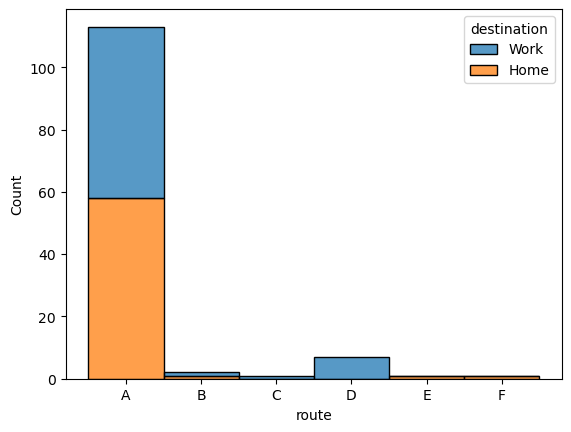

In [23]:
sns.histplot(data = full_df, x = 'route', hue = 'destination', multiple = 'stack')
plt.show()

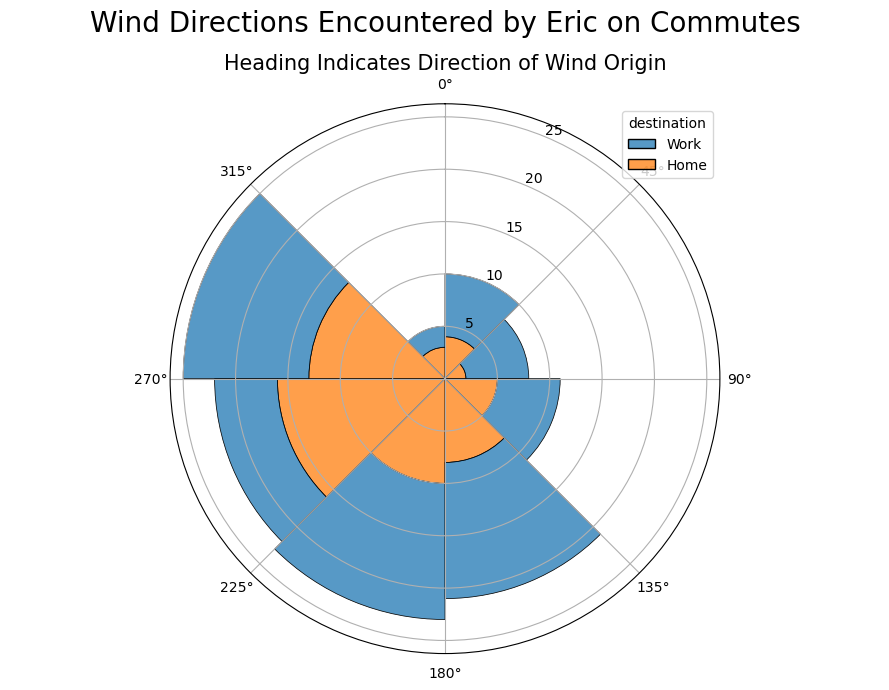

In [106]:
bins = np.linspace(0, 2*np.pi, 9)
fig, ax = plt.subplots(figsize = (9, 7))
ax.axis('off')
ax = plt.subplot(111, projection = 'polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
bars = sns.histplot(data = wind_df, x = 'wind_direction_rad', hue = 'destination', bins = bins, multiple = 'stack', edgecolor = 'k')
ax.set_ylabel('')
ax.set_xlabel('')
fig.suptitle('Wind Directions Encountered by Eric on Commutes', fontsize = 20) 
ax.set_title('Heading Indicates Direction of Wind Origin', fontsize = 15)
plt.tight_layout()
plt.show()

Eric's commute is primarily westward in the morning and eastward in the evening. The wind typically originates in the west or south, so he rarely gets a helping wind on his morning commute.

In [25]:
full_df['weather'].value_counts()

weather
Clear      109
Drizzle     14
Rain         2
Name: count, dtype: int64

Eric clearly avoids rain as much as possible. Only twice did he ride in conditions that *may* have been worse than a drizzle. Again, the WMO code for rain appeared at some point in the 2-hour estimated weather window for his commute. Knowing Pittsburgh's weather, it's entirely possible he avoided the rain.

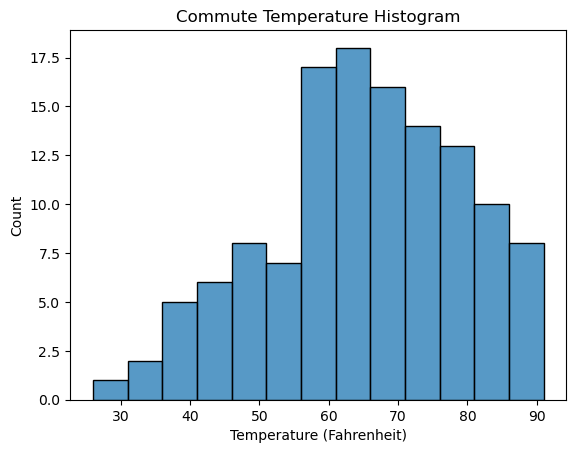

In [26]:
sns.histplot(data = full_df, x = 'temp_f', binwidth = 5)
plt.title('Commute Temperature Histogram')
plt.xlabel('Temperature (Fahrenheit)')
plt.show()

Eric clearly prefers not to ride in sub-freezing temperatures, and who could blame him?

#### Rides per year and yearly average speeds ####
I need these figures for my presentation so I slotted them in here.

In [91]:
yearly_rides = full_df.copy()
yearly_rides['year'] = yearly_rides.apply(lambda x: x['date'].year, axis = 1)
yearly_df = yearly_rides.groupby('year').agg({'date': pd.Series.nunique}).reset_index(drop = False).rename(columns = {'year': 'Year', 'date': 'Days Ridden'}) 
yearly_df

,Year,Days Ridden
0,2019,29
1,2021,13
2,2022,14
3,2023,9
4,2024,2


In [92]:
yearly_df.to_csv('yearly.csv')

In [138]:
yearly_speeds

,year,destination,avg_mph
0,2019,Home,11.498929
1,2019,Work,13.416786
2,2021,Home,11.243846
3,2021,Work,13.513333
4,2022,Home,11.419167
5,2022,Work,13.526923
6,2023,Home,11.267143
7,2023,Work,13.582222
8,2024,Home,10.940000
9,2024,Work,12.990000


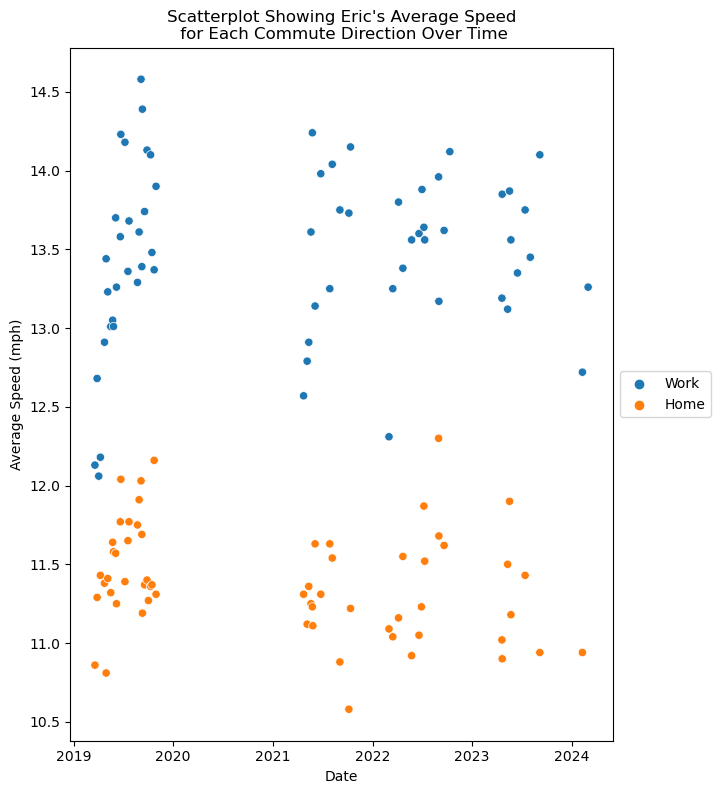

In [127]:
fig, ax = plt.subplots(figsize = (7, 9))

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

sns.scatterplot(data = full_df, x = 'date', y = 'avg_mph', hue = 'destination', ax = ax)
plt.title("Scatterplot Showing Eric's Average Speed\n for Each Commute Direction Over Time")
plt.ylabel('Average Speed (mph)')
plt.xlabel('Date')
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) 
plt.show()

Suddenly, we have a clear picture emerging. First, I can see that Eric was really taking biking seriously in 2019. He showed a general trend of picking up speed throughout the year on his commutes. I'll dive further into this shape later. We can also clearly see that Eric worked from home during all of 2020 due to COVID.

While the above dataframe demonstrates a fairly level mean riding pace on his commutes to work across all 4 years, we see a slight negative trend in the mean pace on his return trips. We can also see that illustration of Simpson's paradox that I mentioned earlier. Each year taken on its own shows a positive trend of pace over time. But across all 4 years, we see average pace falling.

In [103]:
full_df.groupby('destination')['avg_mph'].mean()

destination
Home    11.393115
Work    13.467187
Name: avg_mph, dtype: float64

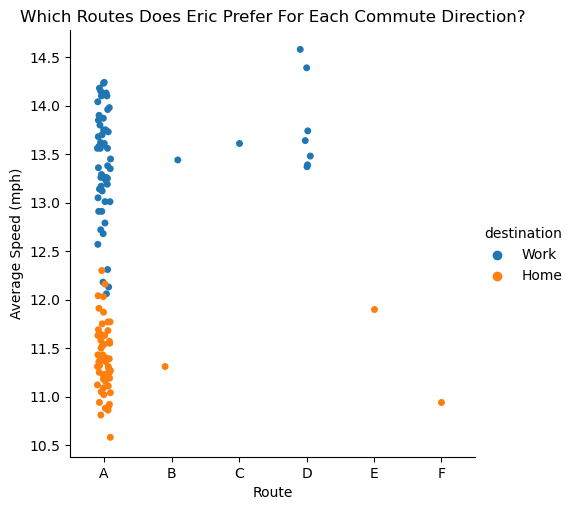

In [28]:
sns.catplot(data = full_df, x = 'route', y = 'avg_mph', hue = 'destination')
plt.title('Which Routes Does Eric Prefer For Each Commute Direction?')
plt.xlabel('Route')
plt.ylabel('Average Speed (mph)')
plt.show()

In [29]:
D_avg = full_df.loc[full_df['route'] == 'D']['avg_mph'].mean()
time_saved = (0.1 * 3600 / D_avg)
print(f'Eric averages {D_avg:0.2f} mph on route D.\nThe 0.1 mile savings over\
 route A accounts for a {time_saved:0.0f}-second savings on his morning commute.')

Eric averages 13.80 mph on route D.
The 0.1 mile savings over route A accounts for a 26-second savings on his morning commute.


Clearly Eric prefers route A. D appears to allow Eric a faster average speed, but I'll test that hypothesis later to see if we can definitively say D is a faster route. Eric has posted 2 speeds on route D that exceed his historical highs on route A. Time, however, is the confounding factor. Eric posted those speeds during the upward trend in 2019 when he was increasing his fitness level. He has yet to approach those speeds since taking 2020 off.

In [30]:
pd.crosstab(full_df['route'], full_df['weekday'])

weekday,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday
route,,,,,,
A,35,10,3,18,20,27
B,1,0,0,0,1,0
C,0,0,0,1,0,0
D,1,0,1,1,2,2
E,0,0,0,1,0,0
F,0,0,0,0,0,1


Does Eric seem to have some sort of weekday/bike route bias? No, he just seems to generally prefer route A and doesn't like to bike on Mondays. Maybe he often works from home on Mondays.

In [31]:
morning_2019_df = (full_df.loc[
                   (full_df['date'].dt.year == 2019) & 
                   (full_df['destination'] == 'Work') &
                   (full_df['route'] == 'A')]
                  )

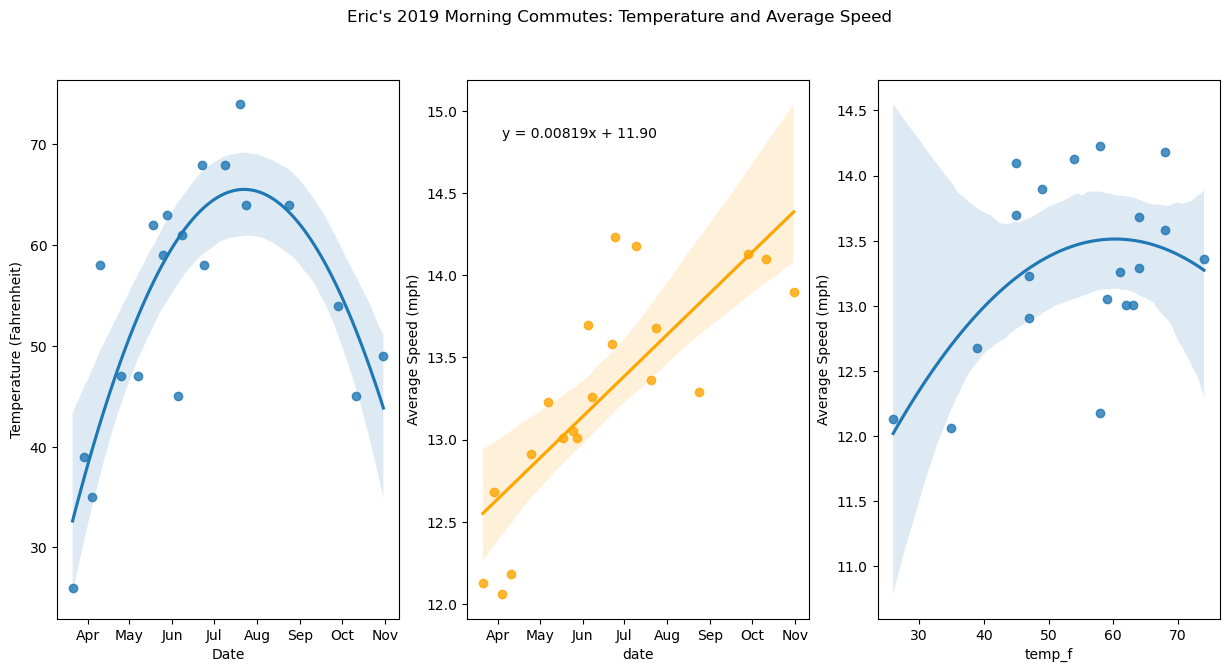

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (15, 7))

ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].xaxis.set_major_formatter(DateFormatter("%b"))
ax[1].xaxis.set_major_locator(MonthLocator())
ax[1].xaxis.set_major_formatter(DateFormatter("%b"))

sns.regplot(
    x = morning_2019_df['date'].dt.dayofyear,
    y='temp_f',
    data = morning_2019_df,
    fit_reg=True,
    ci=95,  # Confidence interval at 95%
    order = 2,
    ax=ax[0]
)

ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[1].set_xlabel('Temperature (Fahrenheit)')


l = sns.regplot(
    x = morning_2019_df['date'].dt.dayofyear,
    y = 'avg_mph',
    data = morning_2019_df,
    ax = ax[1],
    color = 'orange',
    order = 1
)

sns.regplot(
    y = 'avg_mph',
    x = 'temp_f',
    data = morning_2019_df,
    ax = ax[2],
    order = 2
)
    



plt.suptitle("Eric's 2019 Morning Commutes: Temperature and Average Speed")

ax[0].set_ylabel('Temperature (Fahrenheit)')
ax[1].set_ylabel('Average Speed (mph)')
ax[2].set_ylabel('Average Speed (mph)')

slope, intercept, r, p, sterr = scipy.stats.linregress(x = l.get_lines()[0].get_xdata(), y = l.get_lines()[0].get_ydata())

ax[1].text(0.1, 0.9, f'y = {slope:0.5f}x + {intercept:0.2f}', horizontalalignment='left', verticalalignment='center', transform=ax[1].transAxes)





plt.show()

It appears that date is a better predictor of temperature and speed than temperature is a predictor of speed. I also grabbed the slope and intercept of the speed vs date regression line to help inform my prior distribution for modeling later.

In [33]:
# Eric only ever used route D to go to work so I don't need to filter for destination.
d_2019_df = (full_df.loc[
             (full_df['route'] == 'D') & 
             (full_df['date'].dt.year == 2019)]
             [['date', 'avg_mph', 'temp_f']]
            ).reset_index(drop = True).assign(day_no = lambda x: x['date'].dt.dayofyear - 79)

d_2019_df

,date,avg_mph,temp_f,day_no
0,2019-09-05,14.58,59,169
1,2019-09-08,13.39,70,172
2,2019-09-10,14.39,57,174
3,2019-09-18,13.74,54,182
4,2019-10-15,13.48,38,209
5,2019-10-23,13.37,43,217


In [34]:
a_2019_df = (full_df.loc[
             (full_df['route'] == 'A') & 
             (full_df['date'].dt.year == 2019) & 
             (full_df['destination'] == 'Work')]
             [['date', 'avg_mph', 'temp_f']]
            ).reset_index(drop = True).assign(day_no = lambda x: x['date'].dt.dayofyear - 79) # Start at the date of the first ride
a_2019_df.head()

,date,avg_mph,temp_f,day_no
0,2019-03-20,12.13,26,0
1,2019-03-28,12.68,39,8
2,2019-04-03,12.06,35,14
3,2019-04-09,12.18,58,20
4,2019-04-24,12.91,47,35


### Hypothesis ###
My hypothesis is that route D has some topographical/infrastructure features that enable a higher average speed. What are the chances we'd see speeds at least this extreme if Eric were to have continued riding only route A in 2019? I already observed a positive trend in Eric's average pace over time in 2019, especially on his morning commute. I need to model the time-series distribution of these speeds and see if I ever observe any times as extreme as those he posted on route D when he posted them in september and October.

In [35]:
early_morning_df = (full_df.loc[
                        (full_df['destination'] == 'Work') & 
                        (full_df['route'] == 'A') & 
                        (full_df['date'].dt.month <= 4)][['date', 'avg_mph']])
early_morning_df.avg_mph.describe()

count    14.000000
mean     12.877857
std       0.596595
min      12.060000
25%      12.375000
50%      12.815000
75%      13.257500
max      13.850000
Name: avg_mph, dtype: float64

In [36]:
A_speed_df = (full_df.loc[
                  (full_df['route'] == 'A') &
                  (full_df['destination'] == 'Work')]
                  [['date', 'avg_mph']])
A_speed_df.avg_mph.describe()

count    55.000000
mean     13.422909
std       0.558837
min      12.060000
25%      13.130000
50%      13.560000
75%      13.860000
max      14.240000
Name: avg_mph, dtype: float64

When Eric begins riding for the season (defined as rides in January, February, March, or April), on specifically route A, he averages a speed of almost 13 mph on his way to work, with a standard deviation of 0.6 mph. I'll use this information to create my prior for Eric's base fitness level. Overall, his morning route A commute speed has an observed std of 0.56 mph.

## Model ##

### Assumptions ###
* Fitness level can be treated as linear over this short amount of time. It's likely more of a logarithmic curve over longer periods and parabolic over a lifetime. I'll assume Eric has some base fitness intercept and a fitness factor slope that causes his fitness level to increase over time with training.

    * $fitness_{day} = baseFitness + fitnessFactor * days + \epsilon$

* I'll assume that speed is directly proportional to fitness (disregarding temperature, route, day of the week, mood, etc.)
* I'll assume that Eric's true average pace is normally distributed for any given day
### Bayesian Model ###

* $speed \sim \mathcal{N}(baseFitness + fitnessFactor * day, \sigma)$
    * $speed \sim \mathcal{N}(\beta_0 + \beta_1 * day, \sigma)$
### Priors ###
* $\beta_0 \sim \mathcal{N}(12.875, 0.6)$ Assume base fitness (in terms of early season avg_mph) is normally distributed and centered around 12.875 with std 0.6
* $\beta_1 \sim \mathcal{N}(0.01, 0.5)$ Assume a speed increase of 0.01 mph per day with a lot of uncertainty
* $\sigma \sim \mathcal{N}(0, 1)$ Assume a wide standard deviation of speed, centered around 0

In [37]:
X = a_2019_df['day_no']
y = a_2019_df['avg_mph']

In [38]:
with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', mu = 11.50, sigma = 1) # Intercept prior
    beta_1 = pm.Normal('beta_1', mu = 0.001, sigma = 0.5) # Slope prior
    sigma = pm.Normal('sigma', mu = 0, sigma = 1) # Error term prior
    
    predicted_speed = beta_0 + beta_1 * X
    likelihood = pm.Normal('likelihood', mu = predicted_speed, sigma = sigma, observed = y)

    num_draws = 2000

    trace = pm.sample(num_draws, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


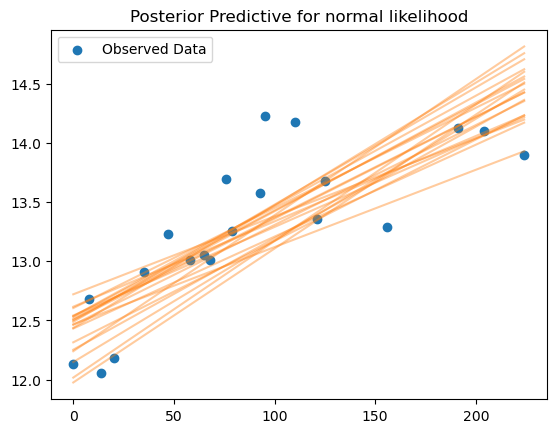

In [39]:
post = az.extract(trace, num_samples = 20)
x_plot = xr.DataArray(np.linspace(X.min(), X.max(), 100), dims = 'plot_id')
lines = post['beta_0'] + post['beta_1'] * x_plot

plt.scatter(X, y, label = 'Observed Data')
plt.plot(x_plot, lines.transpose(), alpha = 0.4, color = 'C1')
plt.legend(loc = 0)
plt.title('Posterior Predictive for normal likelihood')
plt.show()

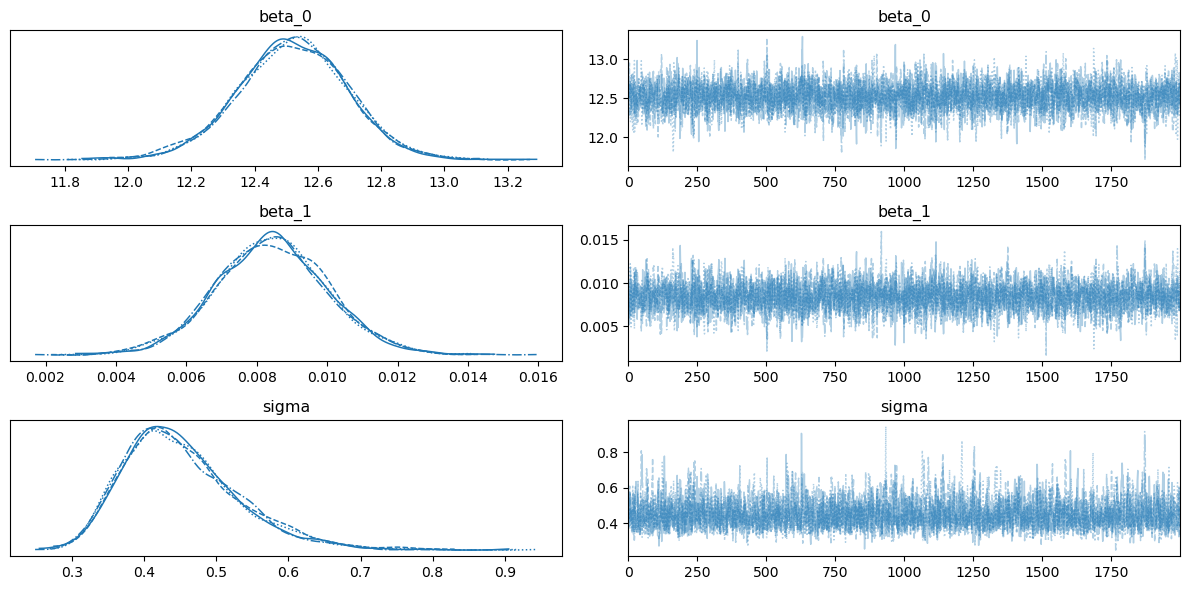

In [40]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [41]:
pd.set_option("display.precision", 6)
post_df = pd.DataFrame(az.summary(trace, round_to = 6))
post_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,12.519277,0.175212,12.181155,12.842162,0.002959,0.002093,3509.113816,3666.723726,1.000204
beta_1,0.008434,0.001596,0.005358,0.011427,0.000026,0.000019,3680.203264,3766.539002,1.000339
sigma,0.451705,0.080692,0.318616,0.604717,0.001535,0.001115,3044.176287,2820.393425,1.000286


In [42]:
beta_0_max = post_df.loc['beta_0']['hdi_97%']
beta_0_min = post_df.loc['beta_0']['hdi_3%']
beta_1_max = post_df.loc['beta_1']['hdi_97%']
beta_1_min = post_df.loc['beta_1']['hdi_3%']
sigma_max = post_df.loc['sigma']['hdi_97%']
sigma_min = post_df.loc['sigma']['hdi_3%']

y_max = beta_0_max + beta_1_max * x_plot + sigma_max

y_min = beta_0_min + beta_1_min * x_plot + sigma_min


In [43]:
beta_0_mean = post_df.loc['beta_0']['mean']
beta_0_sd = post_df.loc['beta_0']['sd']

beta_1_mean = post_df.loc['beta_1']['mean']
beta_1_sd = post_df.loc['beta_1']['sd']

sigma_mean = post_df.loc['sigma']['mean']
sigma_sd = post_df.loc['sigma']['sd']

y_mean = beta_0_mean + beta_1_mean * x_plot + sigma_mean

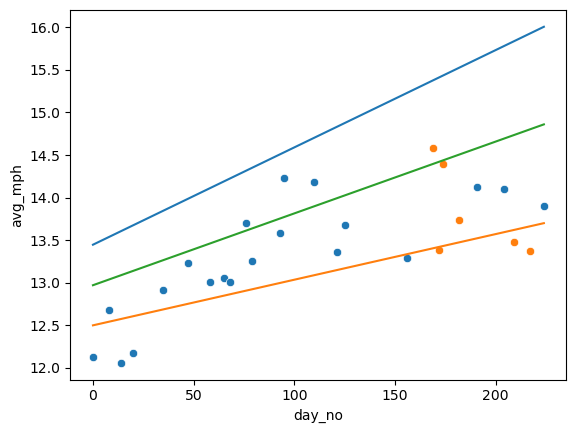

In [44]:
sns.lineplot(x = x_plot, y = y_max)
sns.lineplot(x = x_plot, y = y_min)
sns.lineplot(x = x_plot, y = y_mean)
sns.scatterplot(data = a_2019_df, x = 'day_no', y = 'avg_mph')
sns.scatterplot(data = d_2019_df, x = 'day_no', y = 'avg_mph')
plt.show()

The intervals above, along with the data, show a couple things. 
1. This particular model doesn't find that Eric's performance on route D was exceptionally fast.
2. Eric's slow speeds on route D were actually exceptionally slow.

This tells me nothing but that my model was poor. Even if fitness is linear, sometimes you just don't feel like riding that fast. I need a different distribution shape to reflect that slower speeds remain possible even as faster speeds become possible. I also need a function that has a logarithmic shape, as linear progress over a year seems infeasible with such infrequent training.

In [45]:
x_days = d_2019_df['day_no'].values

predicted_speeds = {}
predicted_means = []

for day in x_days:
    
    pred_speed_mean = beta_0_mean + beta_1_mean * day 

    pred_speed_dist = np.random.normal(pred_speed_mean, sigma_mean, size = 1000)

    predicted_speeds.update({f'Day {day}': pred_speed_dist})
    predicted_means.append(pred_speed_mean.round(2))

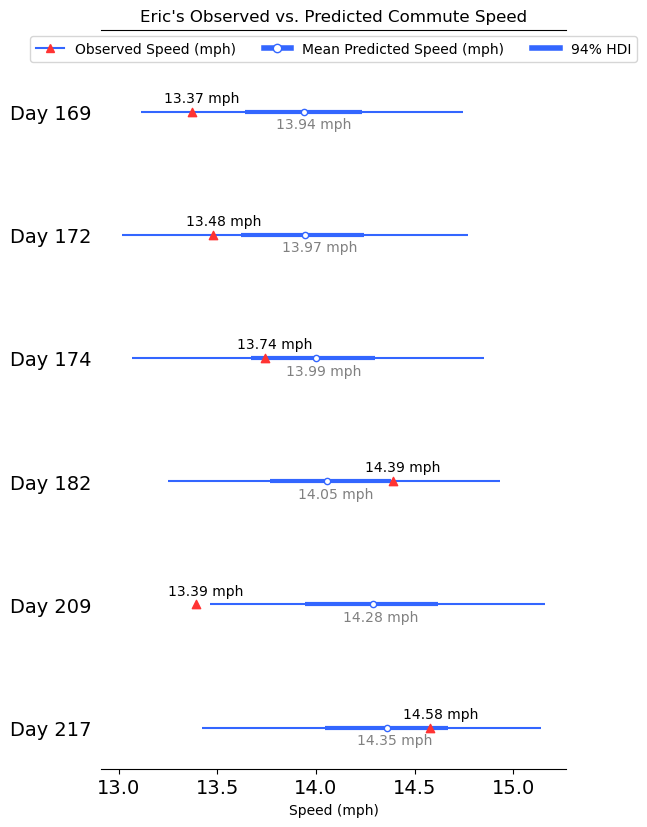

In [46]:
from matplotlib.lines import Line2D

d_speeds = d_2019_df['avg_mph'].values

axes = az.plot_forest(predicted_speeds, combined = True, colors = '#3366ff')#, linewidth = 2)
axis = axes[0]
ylocs = axis.yaxis.get_majorticklocs()
x_obs = d_speeds
x_pred = sorted(predicted_means, reverse = True)

axis.scatter(x_obs, ylocs, color = '#ff3333', marker = '^', zorder = 100)
axis.set_title("Eric's Observed vs. Predicted Commute Speed")
axis.set_xlabel('Speed (mph)')
for xo, yi in zip(x_obs, ylocs):
    axis.annotate(f'{xo} mph', xy = (xo, yi), xycoords = 'data', xytext = (-20, 7), textcoords = 'offset points', fontsize = 10)

for xp, yi in zip(x_pred, ylocs):
    axis.annotate(f'{xp} mph', xy = (xp, yi), xycoords = 'data', xytext = (-20, -12), textcoords = 'offset points', color = 'gray') 

legend_elements = [Line2D([0], 
                          [0], 
                          color = '#3366ff', 
                          markerfacecolor = '#ff3333', 
                          markeredgecolor = '#ff3333', 
                          label = 'Observed Speed (mph)', 
                          marker = '^'),
                   Line2D([0], 
                          [0], 
                          color = '#3366ff', 
                          markerfacecolor = 'white', 
                          markeredgecolor = '#3366ff', 
                          marker = 'o', 
                          linewidth = 4,
                          label = 'Mean Predicted Speed (mph)'),
                   Line2D([0], 
                          [0], 
                          color = '#3366ff', 
                          linewidth = 4, 
                          label = '94% HDI')
                  ]
axis.legend(handles = legend_elements, ncol = 3, loc = 'upper center')

plt.show()

What have we learned so far?
* Eric's maximum speed did not increase linearly in 2019
* If speed did increase linearly over time, Eric's performance on route D would not be unreasonable to expect on route A.

#### SHAP Model ####
I want to build a random forest model to predict Eric's time to complete a route and use the Shapley Additive Explanations to output feature importances. This is a unique tool because it allows us to open the black box that is a typical machine learning model.

In [48]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import root_mean_squared_error

In [49]:
X = (full_df[['date', 'temp_f', 'destination', 'miles', 'perceived_wind']]
     .assign(day_of_year = lambda x: x['date'].dt.dayofyear)
     .assign(work = lambda x: (x['destination'] == 'Work').astype('int'))
     .drop(['date', 'destination'], axis = 1)
    )
y = full_df['time'] / dt.timedelta(minutes = 1)

In [50]:
numeric_features = ['temp_f', 'miles', 'perceived_wind', 'day_of_year']

numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])

preprocessor = ColumnTransformer([('numerical', numeric_transformer, numeric_features)])

In [51]:
folds = 5

pipe = make_pipeline(preprocessor, 
                     GridSearchCV(RandomForestRegressor(), 
                                  scoring = 'neg_root_mean_squared_error',
                                  param_grid = {'criterion': ['squared_error', 'friedman_mse', 'poisson'],
                                                'max_depth': [3, 5, None],
                                                'bootstrap': [True, False],
                                                'n_jobs': [-1],
                                                'random_state': [14],
                                                'max_features': [1, 2, 'sqrt'],
                                                'verbose': [False]
                                               },
                                  cv =  5,
                                  refit = True
                                 )
                    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/folds, random_state = 14)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp_f', 'miles',
                                                   'perceived_wind',
                                                   'day_of_year'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=RandomForestRegressor(),
                              param_grid={'bootstrap': [True, False],
                                          'criterion': ['squared_error',
                                                        'friedman_mse',
                                                        'poisson'],
                                          'max_depth': [3, 5, None],
                                          'max_features': [1, 2, 'sqrt'],
                                          'n_jobs': [-1], 'random_state': [14],
                                          'verbose': [False]},
                              scoring='neg_root_mean_squared_error'))])

In [63]:
best_params = pipe.named_steps['gridsearchcv'].best_estimator_.get_params()

In [52]:
y_preds = pipe.predict(X_test)
root_mean_squared_error(y_test, y_preds)

2.7742147969005604

The mean prediction error for commute time is about 2 minutes and 45 seconds.

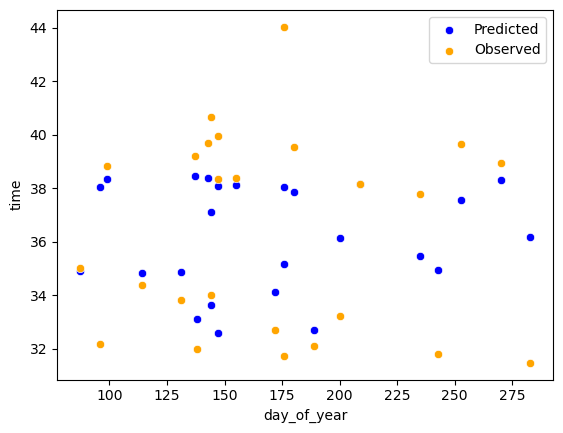

In [53]:
sns.scatterplot(x = X_test['day_of_year'], y = y_preds, color = 'blue', label = 'Predicted')
sns.scatterplot(x = X_test['day_of_year'], y = y_test, color = 'orange', label = 'Observed')
plt.show()

Generally the model has erred on the side of consistency, failing to anticipate broader deviances from the standard pace clusters. For instance, it underestimated Eric's 44 minute commute by 6 minutes and overestimated his 31 minute commute by the same margin.

In [65]:
import shap

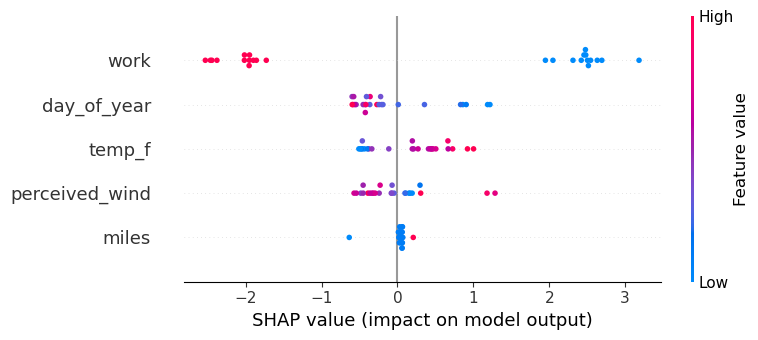

In [69]:
rforest = RandomForestRegressor(**best_params)
rforest.fit(X_train, y_train)

explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

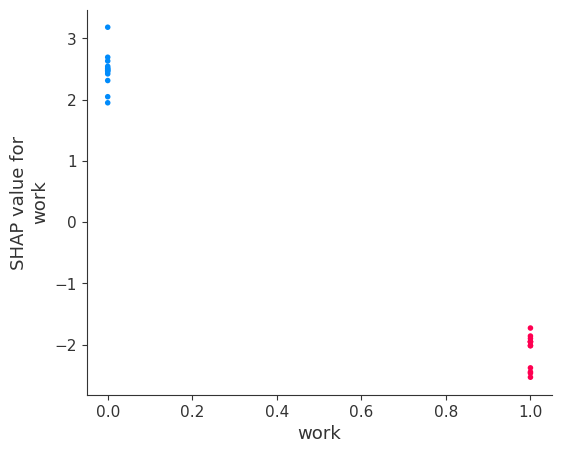

In [84]:
shap.dependence_plot('work', shap_values, X_test, interaction_index = 'work')

These summary and dependence plots are intriguing because they break down the most and least important features of the random forest model. For instance, the model considers the binary 'work' column very important. A 1 indicates that Eric is commuting to work. This value alone corresponds with a reduction in estimated time of nearly 2 minutes from the baseline. A 0, indicating that Eric is riding home, corresponds to an increase of almost 3 minutes above baseline. This is how the model has captured the pattern that Eric takes longer to ride home, which we know is because of the large hill Eric must climb on his return trip.